第6章の問題50のデータ

In [ ]:
# データのダウンロード
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
# !unzip NewsAggregatorDataset.zip

In [3]:
# !sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


第7章の問題60で利用した学習済み単語ベクトル

In [4]:
import gdown
from gensim.models import KeyedVectors

# 学習済み単語ベクトルのダウンロード
# url = "https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM"
# output = 'GoogleNews-vectors-negative300.bin.gz'
# gdown.download(url, output, quiet=True)
 
# ダウンロードファイルのロード
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [5]:
# 70. 単語ベクトルの和による特徴量
import string
import torch

def transform_w2v(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  words = text.translate(table).split()  # 記号をスペースに置換後、スペースで分割してリスト化
  vec = [model[word] for word in words if word in model]  # 1語ずつベクトル化

  return torch.tensor(sum(vec) / len(vec))  # 平均ベクトルをTensor型に変換して出力

In [6]:
# 特徴ベクトルの作成
X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

print(X_train.size())
print(X_train[:5])

torch.Size([10684, 300])
tensor([[ 0.0837,  0.0056,  0.0068,  ...,  0.0751,  0.0433, -0.0868],
        [ 0.0272,  0.0266, -0.0947,  ..., -0.1046, -0.0489, -0.0092],
        [ 0.0577, -0.0159, -0.0780,  ..., -0.0421,  0.1229,  0.0876],
        [-0.0555,  0.0496,  0.0620,  ..., -0.0136,  0.0390, -0.0206],
        [-0.0259,  0.0775, -0.0256,  ..., -0.0364,  0.1126,  0.0063]])


In [7]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category_dict[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category_dict[x]).values)

print(y_train.size())
print(y_train)

torch.Size([10684])
tensor([0, 1, 3,  ..., 0, 3, 2])


In [31]:
# 保存
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_test.pt')

In [8]:
# 71.単層ニューラルネットワークによる予測
from torch import nn

# Single Layer Perceptron Model
class SLPNet(nn.Module):  
  def __init__(self, input_size, output_size):
    super().__init__() # 親クラスであるnn.Moduleの初期化関数を呼び出しています
    self.fc = nn.Linear(input_size, output_size, bias=False)
    # nn.init.normal_(self.fc.weight, 0.0, 1.0)  # 正規乱数で重みを初期化

  def forward(self, x): # 順伝播関数を定義
    x = self.fc(x) # 入力データxが初期化関数で作成した線形レイヤーに渡されます
    return x


In [29]:
model = SLPNet(300, 4)  # 単層ニューラルネットワークの初期化
y_hat_1 = torch.softmax(model(X_train[:1]), dim=-1)
print(y_hat_1)

tensor([[0.2427, 0.2529, 0.2580, 0.2464]], grad_fn=<SoftmaxBackward>)


In [30]:
Y_hat = torch.softmax(model(X_train[:4]), dim=-1)
print(Y_hat)

tensor([[0.2427, 0.2529, 0.2580, 0.2464],
        [0.2536, 0.2282, 0.2520, 0.2662],
        [0.2534, 0.2503, 0.2436, 0.2527],
        [0.2488, 0.2440, 0.2560, 0.2513]], grad_fn=<SoftmaxBackward>)


In [31]:
# 72. 損失と勾配の計算
criterion = nn.CrossEntropyLoss()

In [32]:
# 学習データの事例x1に対する損失と勾配
l_1 = criterion(model(X_train[:1]), y_train[:1])  # 入力ベクトルはsoftmax前の値
model.zero_grad()  # 勾配をゼロで初期化
l_1.backward()  # 勾配を計算
print(f'損失: {l_1:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

tensor(1.4158, grad_fn=<NllLossBackward>)
損失: 1.4158
勾配:
tensor([[-0.0634, -0.0043, -0.0052,  ..., -0.0569, -0.0328,  0.0657],
        [ 0.0212,  0.0014,  0.0017,  ...,  0.0190,  0.0110, -0.0220],
        [ 0.0216,  0.0015,  0.0018,  ...,  0.0194,  0.0112, -0.0224],
        [ 0.0206,  0.0014,  0.0017,  ...,  0.0185,  0.0107, -0.0214]])


In [17]:
# 事例集合x1,x2,x3,x4に対する損失と勾配
l = criterion(model(X_train[:4]), y_train[:4])
model.zero_grad()
l.backward()   # 損失に基づいて逆伝播を行い、モデルパラメータの勾配を計算
print(f'損失: {l:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 2.0110
勾配:
tensor([[-0.0157,  0.0010, -0.0069,  ..., -0.0233,  0.0027,  0.0250],
        [-0.0054, -0.0049,  0.0251,  ...,  0.0277,  0.0149, -0.0010],
        [ 0.0278, -0.0051, -0.0247,  ..., -0.0009, -0.0059, -0.0094],
        [-0.0067,  0.0090,  0.0065,  ..., -0.0035, -0.0117, -0.0146]])


In [9]:
# 73. 確率的勾配降下法（SGD）による学習

from torch.utils.data import Dataset #　Datasetは特徴ベクトルとラベルベクトルを合わせて保持することができる型

class NewsDataset(Dataset):
  def __init__(self, X, y):  # datasetの構成要素を指定
    self.X = X
    self.y = y

  def __len__(self):  # len(dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, idx):  # dataset[idx]で返す値を指定
    return [self.X[idx], self.y[idx]]

In [10]:
from torch.utils.data import DataLoader
# DataloaderはDatasetを入力とし、指定したサイズ(batch_size)にまとめたデータを順に取り出すことができます。

# Datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

# Dataloaderの作成
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [21]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  loss_train = 0.0
  for i, (inputs, labels) in enumerate(dataloader_train):
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step() # 勾配に基づきパラメーターを更新する

    # 損失を記録
    loss_train += loss.item()
 
  # バッチ単位の平均損失計算
  loss_train = loss_train / i

  # 検証データの損失計算
  model.eval() 
  with torch.no_grad():
    inputs, labels = next(iter(dataloader_valid))
    outputs = model(inputs)
    loss_valid = criterion(outputs, labels)

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')  

epoch: 1, loss_train: 0.4519, loss_valid: 0.3490
epoch: 2, loss_train: 0.3112, loss_valid: 0.3221
epoch: 3, loss_train: 0.2823, loss_valid: 0.3110
epoch: 4, loss_train: 0.2654, loss_valid: 0.3164
epoch: 5, loss_train: 0.2549, loss_valid: 0.3015
epoch: 6, loss_train: 0.2476, loss_valid: 0.3056
epoch: 7, loss_train: 0.2421, loss_valid: 0.3038
epoch: 8, loss_train: 0.2380, loss_valid: 0.3031
epoch: 9, loss_train: 0.2348, loss_valid: 0.3014
epoch: 10, loss_train: 0.2319, loss_valid: 0.3024


In [97]:
# a = torch.tensor([1,2,3])
# b = torch.tensor([5,2,3])
# (a == b).sum().item()

2

In [22]:
# 74. 正解率の計測
def calculate_accuracy(model, loader):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return correct / total

In [23]:
acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.926
正解率（評価データ）：0.906


In [24]:
# 75. 損失と正解率のプロット
def calculate_loss_and_accuracy(model, criterion, loader):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total

In [25]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 20
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
 
  # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')  

epoch: 1, loss_train: 0.3313, accuracy_train: 0.8824, loss_valid: 0.3776, accuracy_valid: 0.8548
epoch: 2, loss_train: 0.2843, accuracy_train: 0.9042, loss_valid: 0.3339, accuracy_valid: 0.8862
epoch: 3, loss_train: 0.2625, accuracy_train: 0.9120, loss_valid: 0.3180, accuracy_valid: 0.8892
epoch: 4, loss_train: 0.2562, accuracy_train: 0.9136, loss_valid: 0.3204, accuracy_valid: 0.8855
epoch: 5, loss_train: 0.2428, accuracy_train: 0.9183, loss_valid: 0.3106, accuracy_valid: 0.8945
epoch: 6, loss_train: 0.2388, accuracy_train: 0.9197, loss_valid: 0.3123, accuracy_valid: 0.8915
epoch: 7, loss_train: 0.2337, accuracy_train: 0.9216, loss_valid: 0.3106, accuracy_valid: 0.8937
epoch: 8, loss_train: 0.2297, accuracy_train: 0.9223, loss_valid: 0.3118, accuracy_valid: 0.8967
epoch: 9, loss_train: 0.2294, accuracy_train: 0.9218, loss_valid: 0.3143, accuracy_valid: 0.8937
epoch: 10, loss_train: 0.2264, accuracy_train: 0.9247, loss_valid: 0.3111, accuracy_valid: 0.8945
epoch: 11, loss_train: 0.2257

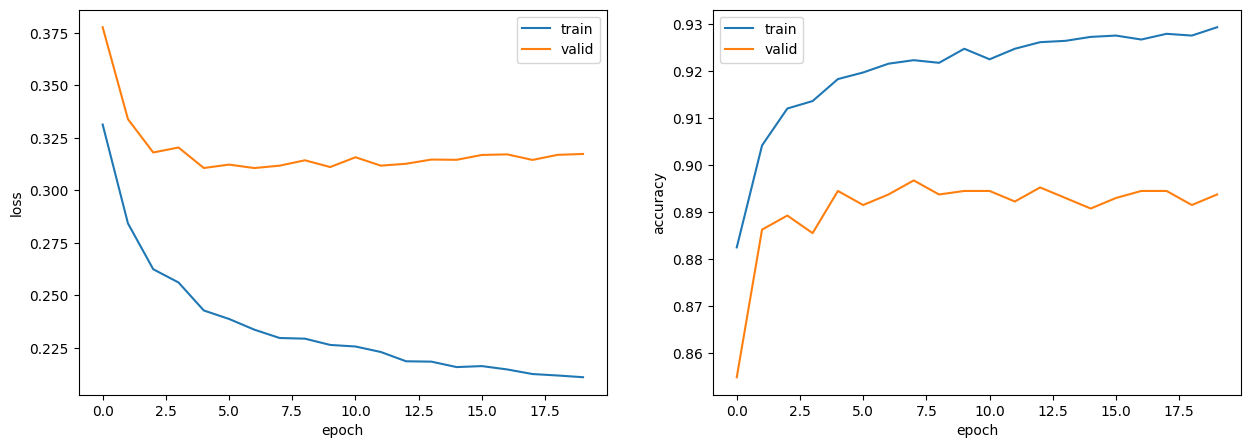

In [26]:
from matplotlib import pyplot as plt
import numpy as np

# 視覚化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [ ]:
# 76. チェックポイント
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 20
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
 
  # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # チェックポイントの保存
  torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'./q76_checkpoint/checkpoint{epoch + 1}.pt')

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}') 

In [28]:
# 77. ミニバッチ化
import time

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):
  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
  
    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # # チェックポイントの保存
    # torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [37]:
# モデルの定義
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1)

バッチサイズ: 1
epoch: 1, loss_train: 0.3322, accuracy_train: 0.8866, loss_valid: 0.3660, accuracy_valid: 0.8683, 3.0015sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3031, accuracy_train: 0.8978, loss_valid: 0.3442, accuracy_valid: 0.8765, 1.6680sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2933, accuracy_train: 0.9006, loss_valid: 0.3350, accuracy_valid: 0.8817, 0.9122sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2890, accuracy_train: 0.9037, loss_valid: 0.3322, accuracy_valid: 0.8840, 0.5802sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2868, accuracy_train: 0.9034, loss_valid: 0.3307, accuracy_valid: 0.8832, 0.4041sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2859, accuracy_train: 0.9040, loss_valid: 0.3298, accuracy_valid: 0.8847, 0.2733sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2856, accuracy_train: 0.9042, loss_valid: 0.3296, accuracy_valid: 0.8840, 0.2285sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2865, accuracy_train: 0.9043, loss_valid: 0.3294, accuracy_valid: 0.8840, 0.1930sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2851, accuracy_

In [38]:
# 78. GPU上での学習
def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total
  

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    
    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [40]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# デバイスの指定
device = torch.device('cuda:0')

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1, device=device)

バッチサイズ: 1
epoch: 1, loss_train: 0.3354, accuracy_train: 0.8823, loss_valid: 0.3827, accuracy_valid: 0.8630, 12.2456sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3045, accuracy_train: 0.8979, loss_valid: 0.3542, accuracy_valid: 0.8750, 6.1838sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2942, accuracy_train: 0.9001, loss_valid: 0.3464, accuracy_valid: 0.8772, 2.4645sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2889, accuracy_train: 0.9032, loss_valid: 0.3410, accuracy_valid: 0.8825, 1.8129sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2871, accuracy_train: 0.9039, loss_valid: 0.3398, accuracy_valid: 0.8817, 0.8390sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2863, accuracy_train: 0.9033, loss_valid: 0.3392, accuracy_valid: 0.8810, 0.6151sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2859, accuracy_train: 0.9041, loss_valid: 0.3388, accuracy_valid: 0.8817, 0.3780sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2847, accuracy_train: 0.9042, loss_valid: 0.3386, accuracy_valid: 0.8817, 0.2750sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2851, accuracy

In [3]:
import torch
from torch import nn
# With Learnable Parameters
m = nn.BatchNorm1d(100)
print(m)
# Without Learnable Parameters
m = nn.BatchNorm1d(100, affine=False)
print(m)
input = torch.randn(20, 100)
print(input)
output = m(input)
print(output)

BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
tensor([[-0.4572,  0.9661, -0.0351,  ...,  0.7540, -0.7345,  0.0058],
        [ 0.6607, -0.3676,  1.3749,  ..., -1.5094,  0.3448, -0.3947],
        [-0.5770, -1.3751,  1.1979,  ..., -1.1950, -1.2788,  0.6454],
        ...,
        [-0.3728, -0.5568, -0.6892,  ..., -0.4798,  1.4975,  2.0362],
        [-0.3103, -0.1032, -1.7851,  ..., -0.0893, -0.0342, -0.0299],
        [ 0.1569,  0.1997, -0.0527,  ...,  0.7458,  0.4049,  0.8142]])
tensor([[-1.6793e-01,  9.9016e-01,  4.9090e-02,  ...,  8.9572e-01,
         -6.8261e-01,  6.3970e-02],
        [ 1.2806e+00, -2.4497e-01,  1.4006e+00,  ..., -1.5994e+00,
          3.3081e-01, -4.1033e-01],
        [-3.2307e-01, -1.1781e+00,  1.2310e+00,  ..., -1.2527e+00,
         -1.1937e+00,  8.2132e-01],
        ...,
        [-5.8538e-02, -4.2028e-01, -5.7787e-01,  ..., -4.6434e-01,
          1.41

In [13]:
# 79. 多層ニューラルネットワーク
from torch import nn
from torch.nn import functional as F

class MLPNet(nn.Module):
  def __init__(self, input_size, mid_size, output_size, mid_layers):
    super().__init__()
    self.mid_layers = mid_layers
    self.fc = nn.Linear(input_size, mid_size)
    self.fc_mid = nn.Linear(mid_size, mid_size)
    self.fc_out = nn.Linear(mid_size, output_size) 
    self.bn = nn.BatchNorm1d(mid_size)

  def forward(self, x):
    x = F.relu(self.fc(x))
    for _ in range(self.mid_layers):
      x = F.relu(self.bn(self.fc_mid(x)))
    x = F.relu(self.fc_out(x))
 
    return x

In [14]:
from torch import optim
import logging
import time

def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total

def train_model(log_filename, dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)
 
 # logの設定
  logging.basicConfig(filename= log_filename, level=logging.INFO, 
                    format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')
  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    
    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'./q79_checkpoint/checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 
    logging.info(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [ ]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = MLPNet(300, 200, 4, 1)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# デバイスの指定
device = torch.device('cuda:0')

# log file の指定
log_filename = "/workplace/Chapter8/q79_training.log"

# モデルの学習
log = train_model(log_filename, dataset_train, dataset_valid, 64, model, criterion, optimizer, 200, device)

追加：Optunaでパラメータの探索

In [22]:
import optuna
from torch import optim

def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total

def train_model_optuna(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)
 
  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    
    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

def objective(trial):
    # Hyperparameters to be optimized
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    mid_size = trial.suggest_categorical('mid_size', [100, 200, 300, 400, 500])
    mid_layers = trial.suggest_int('mid_layers', 1, 5)
    
    # Define the model with hyperparameters
    model = MLPNet(300, mid_size, 4, mid_layers)
    
    # Define the optimizer with learning rate
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    # Define the device
    device = torch.device('cuda:0')

    # Train the model and get the logs
    logs = train_model_optuna(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 200, device)
    
    # Return the final validation acc
    return logs['valid'][-1][1]  

In [24]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f"\nBest parameters are:\n{study.best_params}")

print(f"\nBest value for the objective is:\n{study.best_value}")

print(f"\nBest trial is:\n{study.best_trial}")

[I 2023-08-04 06:51:02,386] A new study created in memory with name: no-name-69ec2741-cc6b-4e04-ad5a-84785b1b2f6e
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:69: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-08-04 06:51:39,248] Trial 0 finished with value: 0.8937125748502994 and parameters: {'batch_size': 32, 'lr': 0.08189710723262056, 'mid_size': 100, 'mid_layers': 1}. Best is trial 0 with value: 0.8937125748502994.
[I 2023-08-04 06:52:51,731] Trial 1 finished with value: 0.7747005988023952 and parameters: {'batch_size': 128, 'lr': 3.6889424315626484e-05, 'mid_size': 500, 'mid_layers': 1}. Best is trial 0 with value: 0.8937125748502994.
[I 2023-08-04 06:53:00,355] Trial 2 finished with value: 0.5217065868263473 and parameters: {'batch_size': 64, 'lr': 0.004641043184427212, 'mid_size': 100, 'mid_layers': 


Best parameters are:
{'batch_size': 64, 'lr': 0.0029966696338596787, 'mid_size': 500, 'mid_layers': 1}

Best value for the objective is:
0.9101796407185628

Best trial is:
FrozenTrial(number=52, state=TrialState.COMPLETE, values=[0.9101796407185628], datetime_start=datetime.datetime(2023, 8, 4, 7, 48, 30, 204205), datetime_complete=datetime.datetime(2023, 8, 4, 7, 49, 1, 249406), params={'batch_size': 64, 'lr': 0.0029966696338596787, 'mid_size': 500, 'mid_layers': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'batch_size': CategoricalDistribution(choices=(32, 64, 128, 256)), 'lr': FloatDistribution(high=0.1, log=True, low=1e-05, step=None), 'mid_size': CategoricalDistribution(choices=(100, 200, 300, 400, 500)), 'mid_layers': IntDistribution(high=5, log=False, low=1, step=1)}, trial_id=52, value=None)
